In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Build an image segmentation model using pytorch

In [2]:
# Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from torchvision import transforms, models
import os

In [35]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    

    def show_samples(self, num_samples=5):
        for i in range(min(num_samples, len(self.images))):
            img_path = os.path.join(self.image_dir, self.images[i])
            mask_path = os.path.join(self.mask_dir, self.images[i].replace(".jpg", ".png"))
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))

            # Display the image
            ax[0].imshow(image)
            ax[0].set_title('Image')
            ax[0].axis('off')

            # Display the mask
            ax[1].imshow(mask, cmap='gray')
            ax[1].set_title('Mask')
            ax[1].axis('off')

            plt.show()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
    

train_img_dir = '/kaggle/input/birdsounddata/new_dataset/train/images'
train_mask_dir = '/kaggle/input/birdsounddata/new_dataset/train/masks'
valid_img_dir = '/kaggle/input/birdsounddata/new_dataset/valid/images'
valid_mask_dir = '/kaggle/input/birdsounddata/new_dataset/valid/masks'
test_img_dir = '/kaggle/input/birdsounddata/new_dataset/test/images'
test_mask_dir = '/kaggle/input/birdsounddata/new_dataset/test/masks'


train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=transform)
valid_dataset = SegmentationDataset(valid_img_dir, valid_mask_dir, transform=transform)
test_dataset = SegmentationDataset(test_img_dir, test_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=16, shuffle=False)

In [36]:
class EncoderDecoder(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(EncoderDecoder, self).__init__()
        
        # Load pretrained ResNet and remove the fully connected layer
        resnet = models.resnet34(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        # Custom decoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(256, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 64)
        
        # Additional upsampling layer to match target shape
        self.upconv_final = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder[:3](x)
        enc2 = self.encoder[3:5](enc1)
        enc3 = self.encoder[5](enc2)
        enc4 = self.encoder[6](enc3)
        bottleneck = self.encoder[7](enc4)
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(dec1)
        
        # Additional upsampling layer to match target shape
        dec_final = self.upconv_final(dec1)
        return torch.sigmoid(self.final_conv(dec_final))


# Initialize the model
model = EncoderDecoder(num_classes=1, pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

EncoderDecoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [38]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay =1e-4)

# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [39]:
from tqdm import tqdm

train_losses = []
valid_losses = []

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            
#             # Debugging shapes
#             print(f"Output shape: {outputs.shape}")
#             print(f"Target shape: {masks.shape}")
            
#             assert outputs.shape == masks.shape, "Output and target shapes do not match!"
#             outputs = outputs.squeeze(1)  
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(valid_loader):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
#                 # Debugging shapes
#                 print(f"Validation Output shape: {outputs.shape}")
#                 print(f"Validation Target shape: {masks.shape}")
                
#                 assert outputs.shape == masks.shape, "Validation output and target shapes do not match!"
                

#                 outputs = outputs.squeeze(1)  
                loss = criterion(outputs, masks)
                valid_loss += loss.item() * images.size(0)
                
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20)

100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 1/20, Training Loss: 0.5149, Validation Loss: 0.3476


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 2/20, Training Loss: 0.2759, Validation Loss: 0.2009


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 3/20, Training Loss: 0.1614, Validation Loss: 0.1245


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 4/20, Training Loss: 0.1133, Validation Loss: 0.1029


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 5/20, Training Loss: 0.0912, Validation Loss: 0.0917


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 6/20, Training Loss: 0.0779, Validation Loss: 0.0864


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 7/20, Training Loss: 0.0682, Validation Loss: 0.0792


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 8/20, Training Loss: 0.0631, Validation Loss: 0.0789


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 9/20, Training Loss: 0.0571, Validation Loss: 0.0778


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 10/20, Training Loss: 0.0511, Validation Loss: 0.0732


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 11/20, Training Loss: 0.0469, Validation Loss: 0.0700


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch 12/20, Training Loss: 0.0443, Validation Loss: 0.0799


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 13/20, Training Loss: 0.0415, Validation Loss: 0.0748


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 14/20, Training Loss: 0.0385, Validation Loss: 0.0731


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 15/20, Training Loss: 0.0360, Validation Loss: 0.0771


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 16/20, Training Loss: 0.0331, Validation Loss: 0.0761


100%|██████████| 13/13 [00:18<00:00,  1.41s/it]


Epoch 17/20, Training Loss: 0.0314, Validation Loss: 0.0786


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch 18/20, Training Loss: 0.0321, Validation Loss: 0.0791


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 19/20, Training Loss: 0.0294, Validation Loss: 0.0858


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]

Epoch 20/20, Training Loss: 0.0295, Validation Loss: 0.0789


In [40]:
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 1/10, Training Loss: 0.0279, Validation Loss: 0.0783


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 2/10, Training Loss: 0.0272, Validation Loss: 0.0829


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 3/10, Training Loss: 0.0257, Validation Loss: 0.0822


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 4/10, Training Loss: 0.0259, Validation Loss: 0.0867


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 5/10, Training Loss: 0.0243, Validation Loss: 0.0863


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 6/10, Training Loss: 0.0235, Validation Loss: 0.0844


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 7/10, Training Loss: 0.0243, Validation Loss: 0.0898


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 8/10, Training Loss: 0.0234, Validation Loss: 0.0863


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 9/10, Training Loss: 0.0215, Validation Loss: 0.0891


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]

Epoch 10/10, Training Loss: 0.0210, Validation Loss: 0.0942


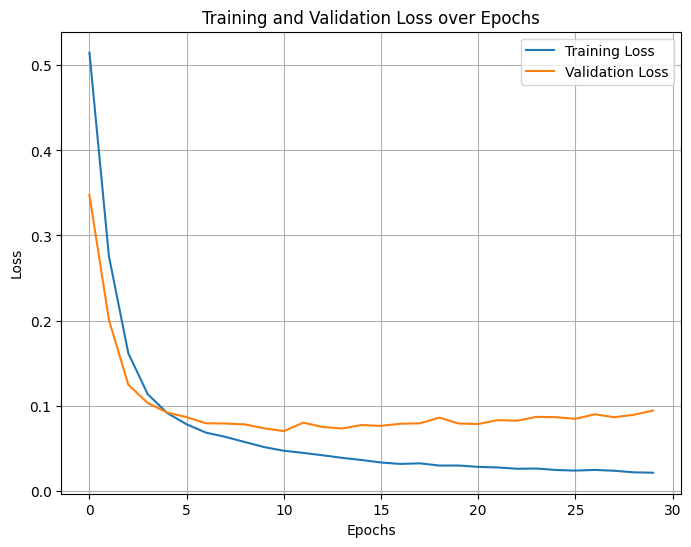

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'BirdSoundSegmentationcheckpoint.pth')

# 3.Evaluate your model using the test images

In [48]:
import numpy as np
from sklearn.metrics import jaccard_score
from tqdm import tqdm
import torch

def evaluate_model(model, test_loader, device):
    model.eval()
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Convert outputs to binary mask

            for output, mask in zip(outputs, masks):
                output = output.cpu().numpy().flatten().astype(int)
                mask = mask.cpu().numpy().flatten().astype(int)

                iou = jaccard_score(mask, output, average='binary')
                dice = 2 * np.sum(output * mask) / (np.sum(output) + np.sum(mask))

                iou_scores.append(iou)
                dice_scores.append(dice)
                
    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)
    
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Dice Coefficient: {avg_dice:.4f}")
    
    return avg_iou, avg_dice





# 4. Your IoU score should be higher than 60

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
avg_iou, avg_dice = evaluate_model(model, test_loader, device)

100%|██████████| 19/19 [01:13<00:00,  3.86s/it]

Average IoU: 0.6225
Average Dice Coefficient: 0.7442


  0%|          | 0/19 [00:00<?, ?it/s]

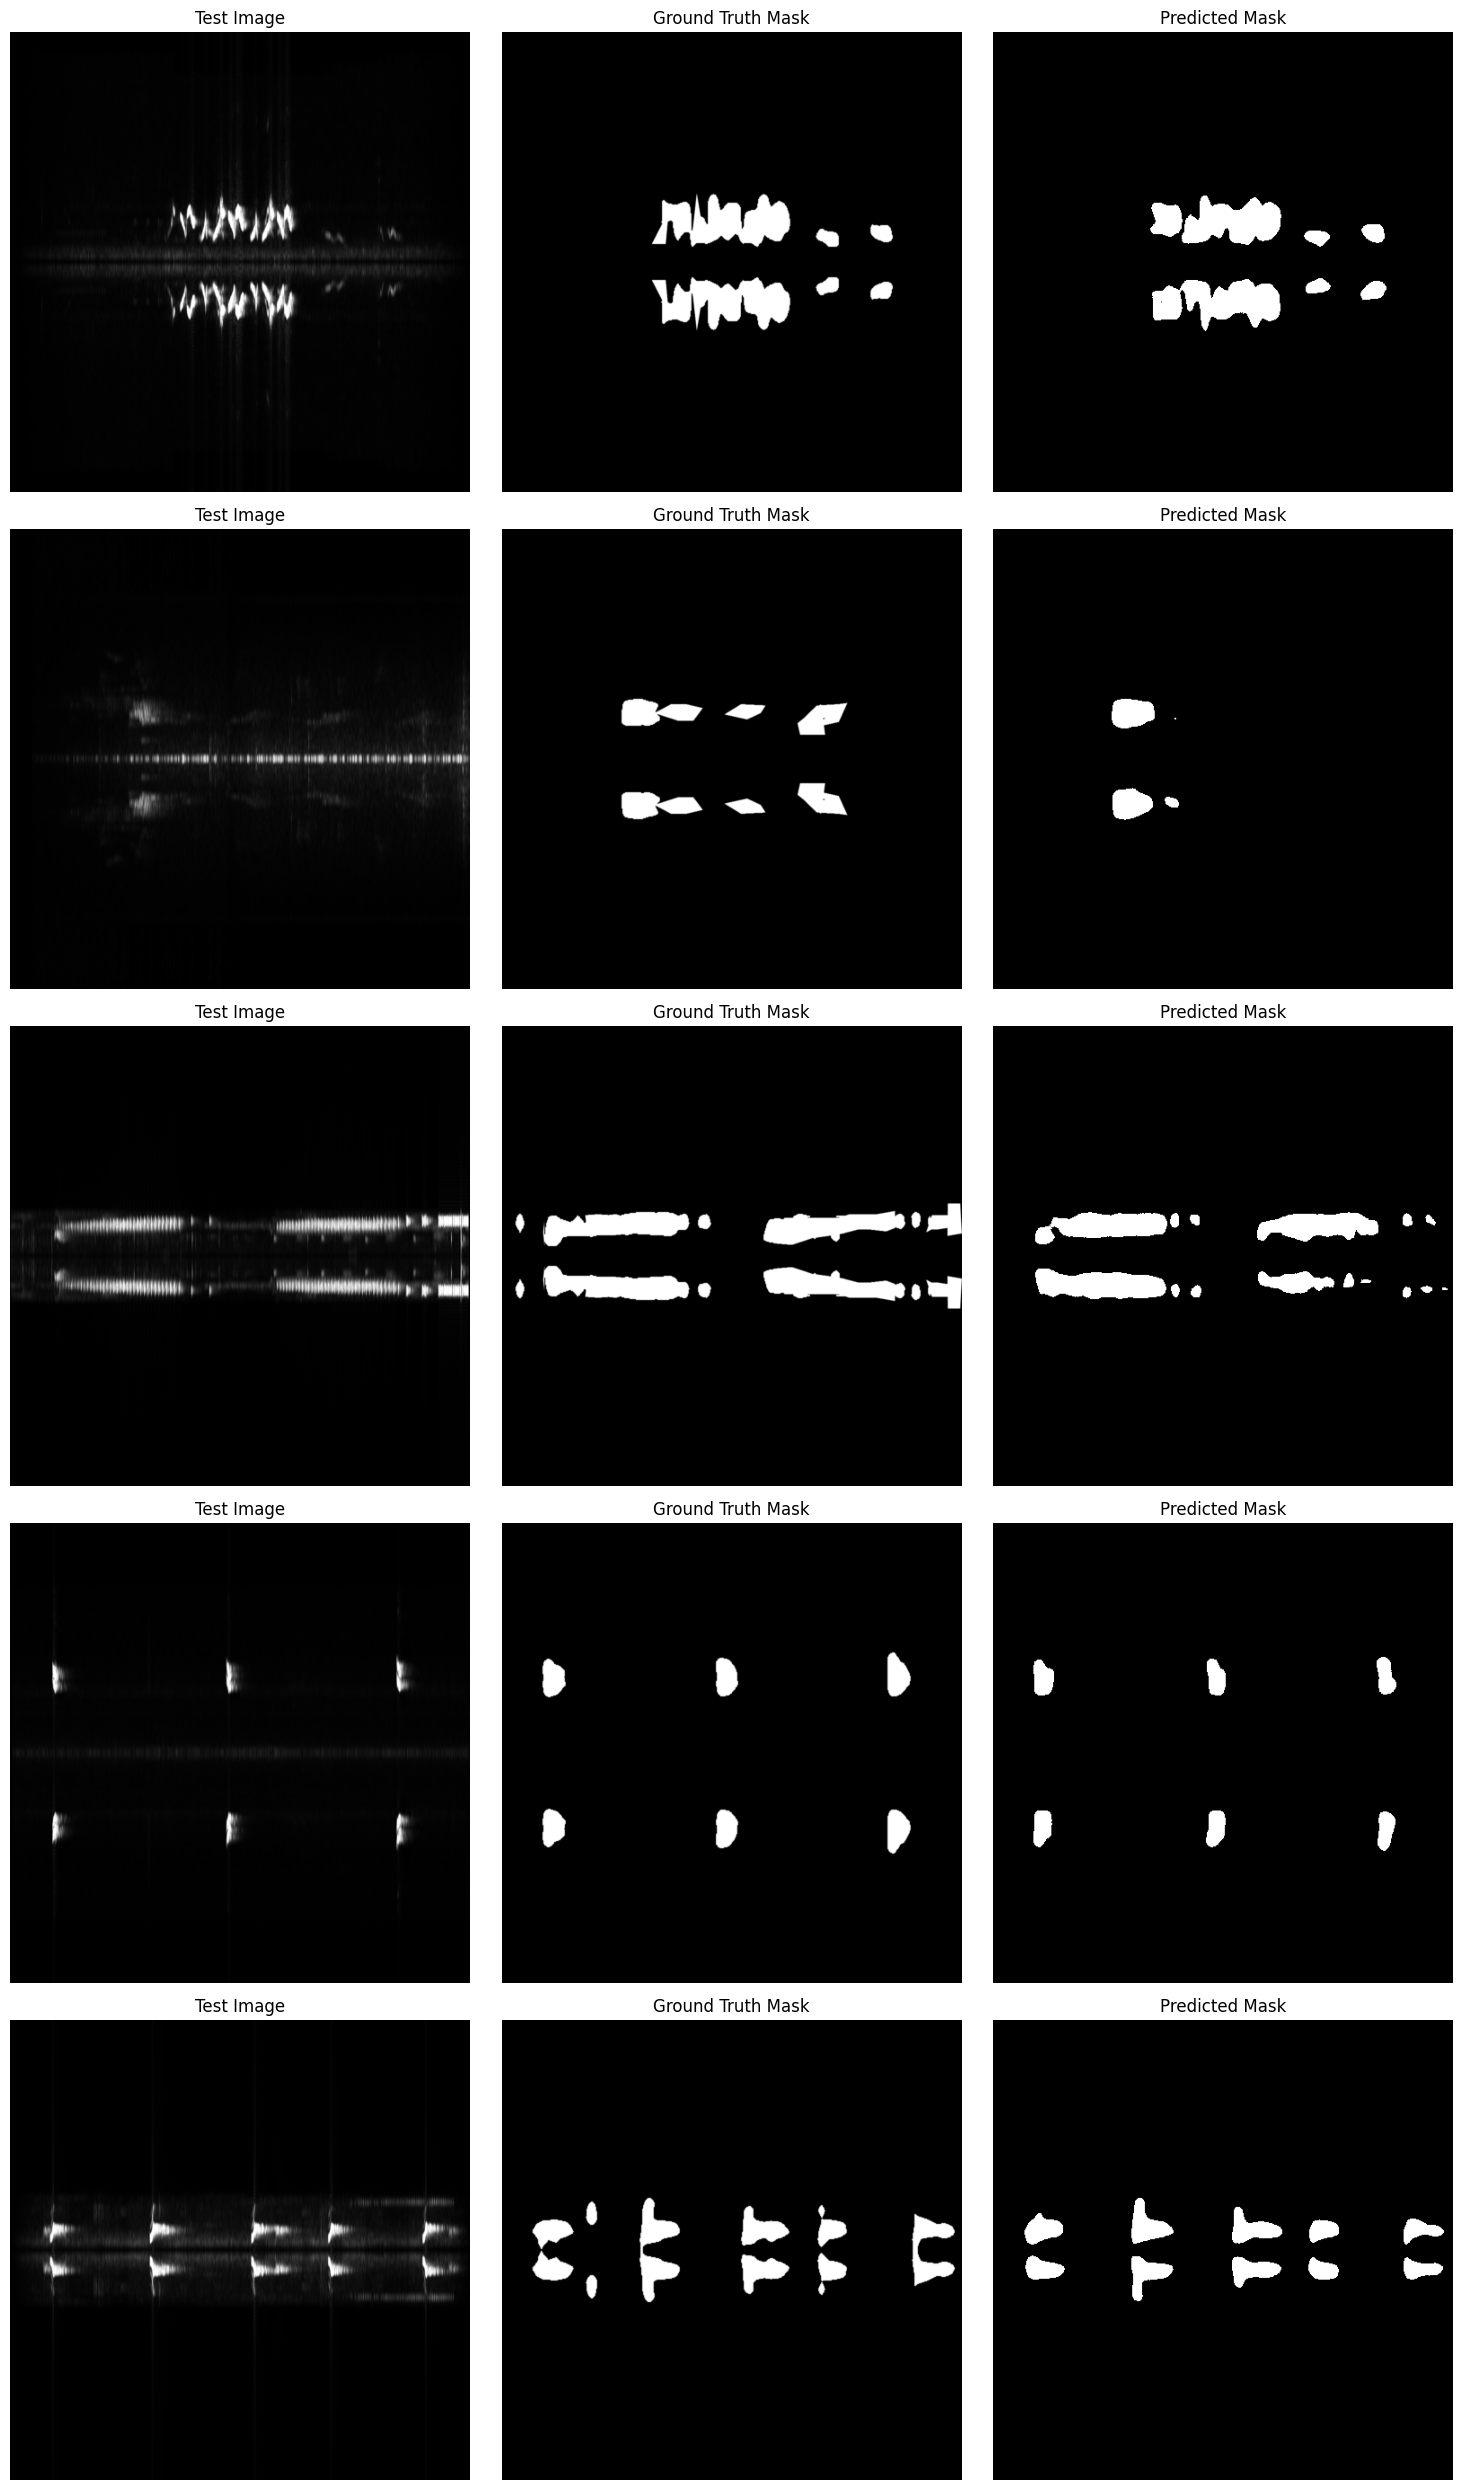

  5%|▌         | 1/19 [00:03<00:59,  3.29s/it]

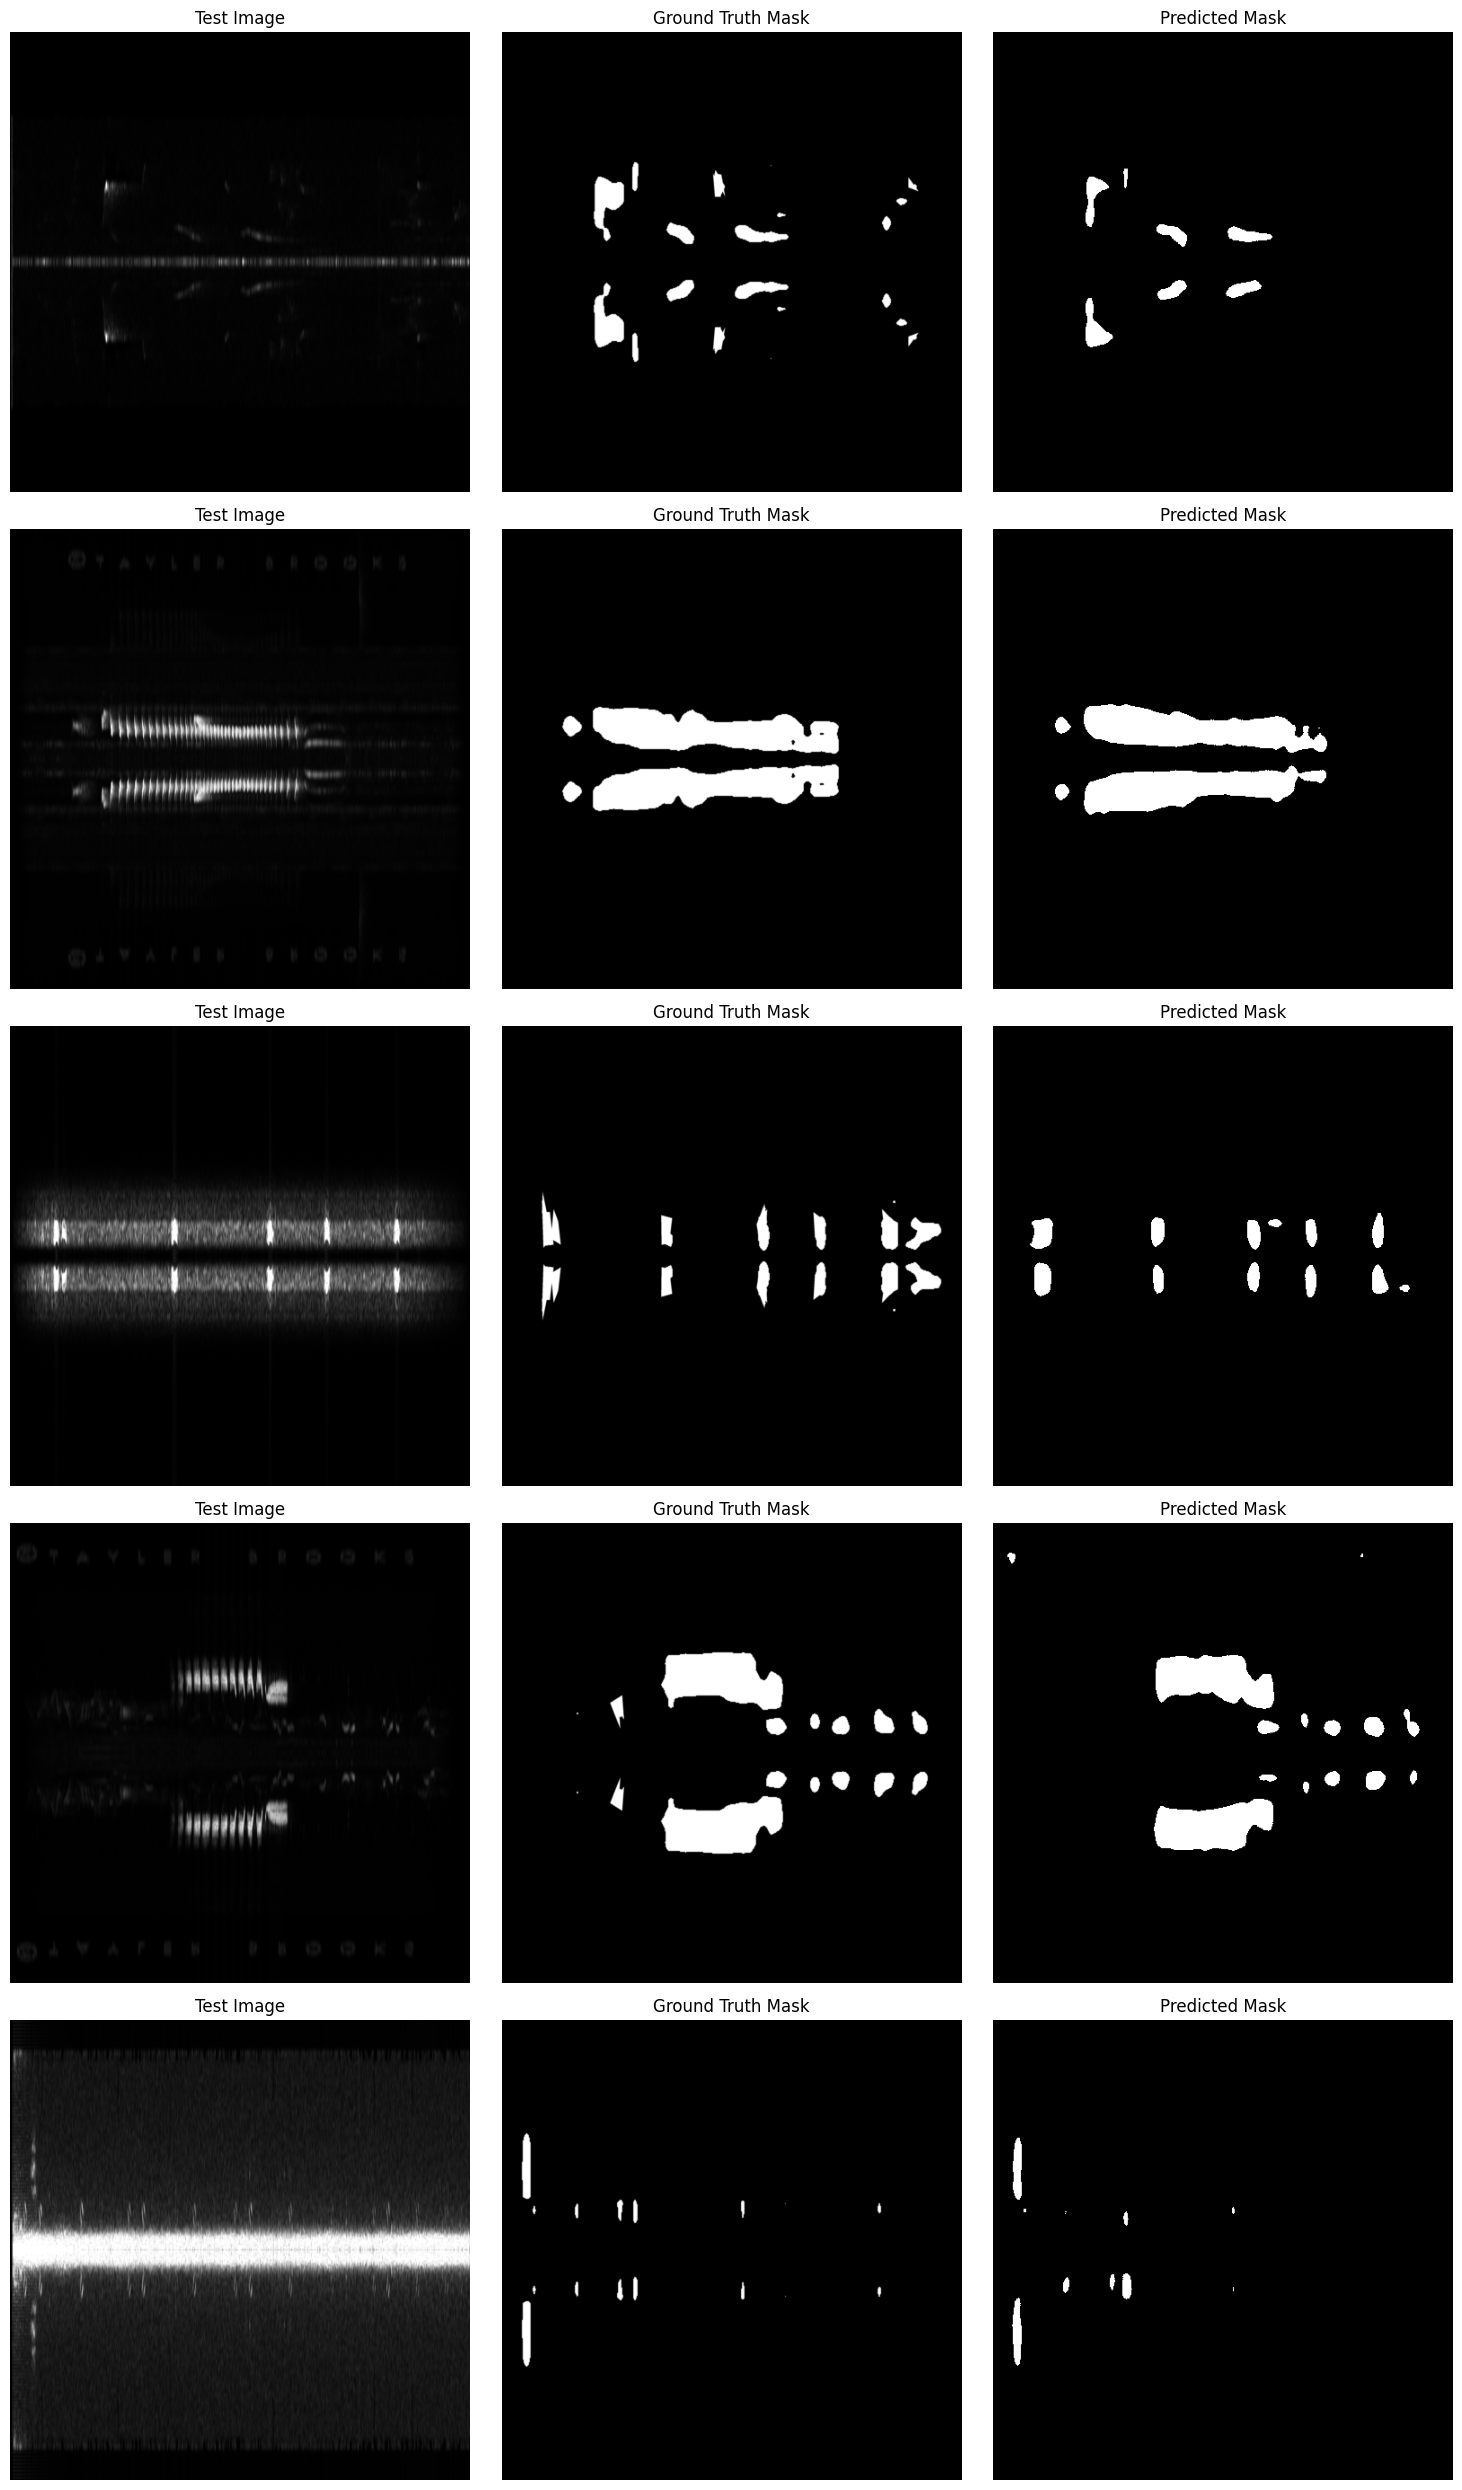

 11%|█         | 2/19 [00:06<00:54,  3.20s/it]

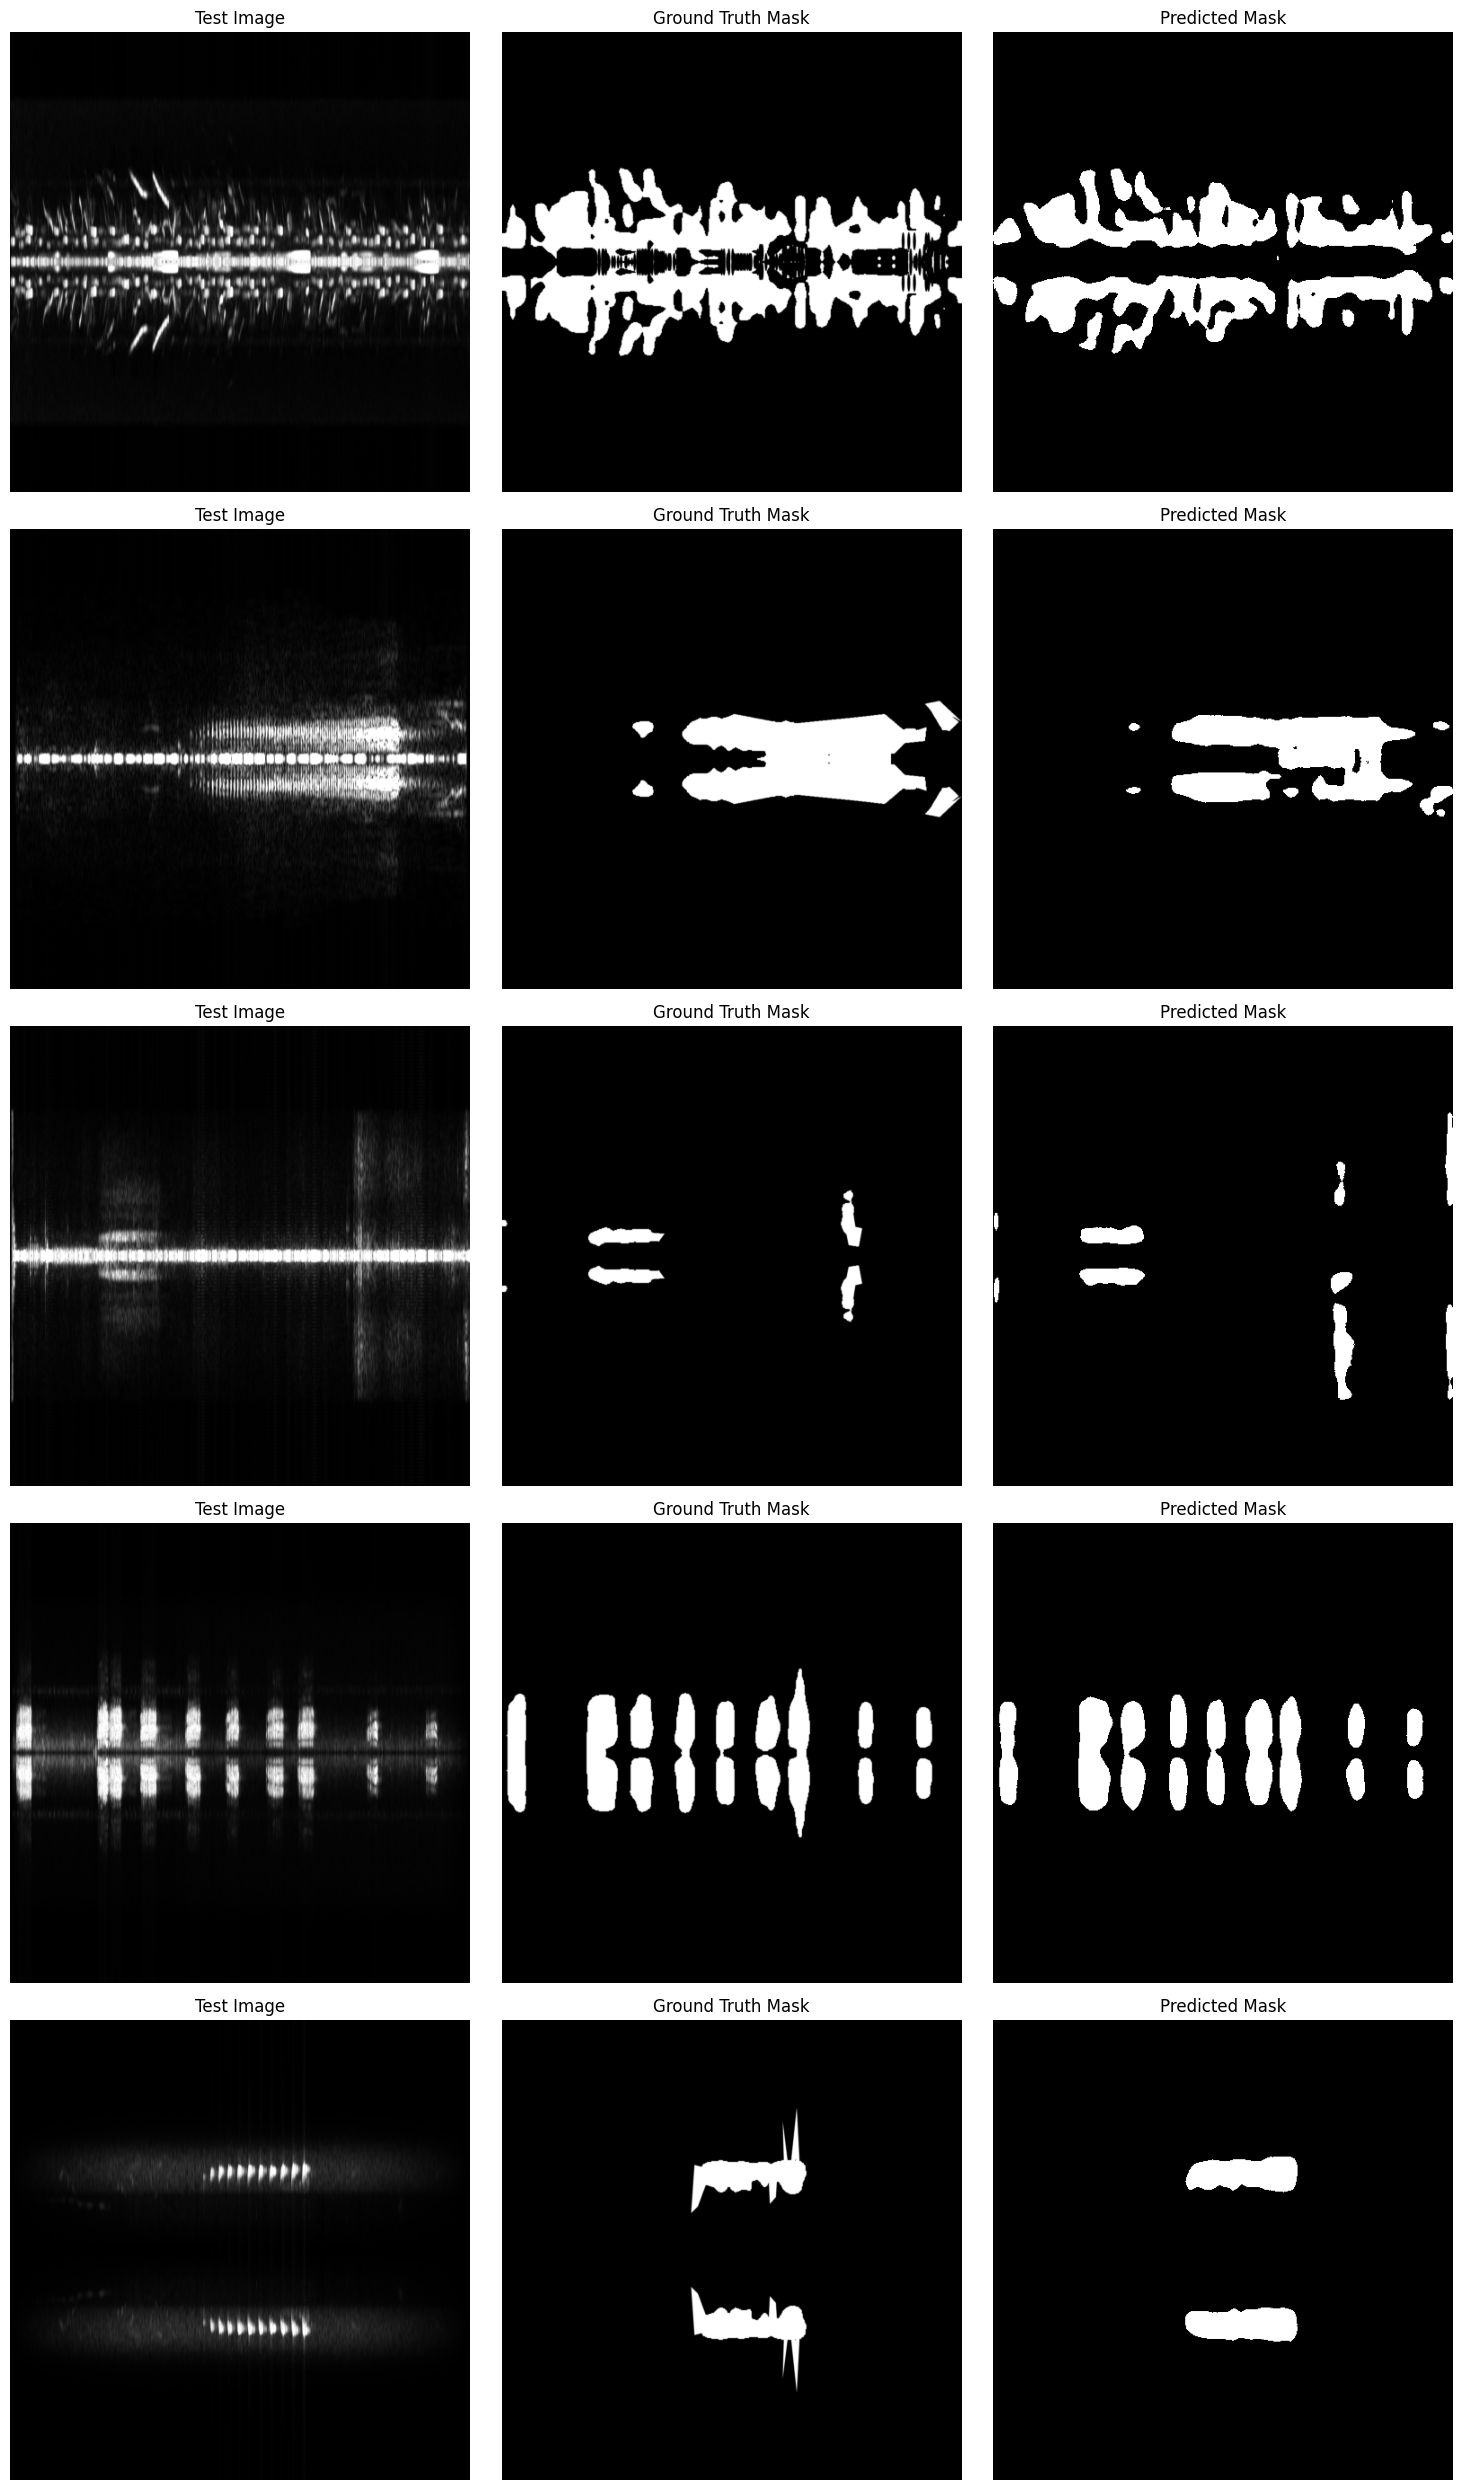

 16%|█▌        | 3/19 [00:09<00:53,  3.36s/it]

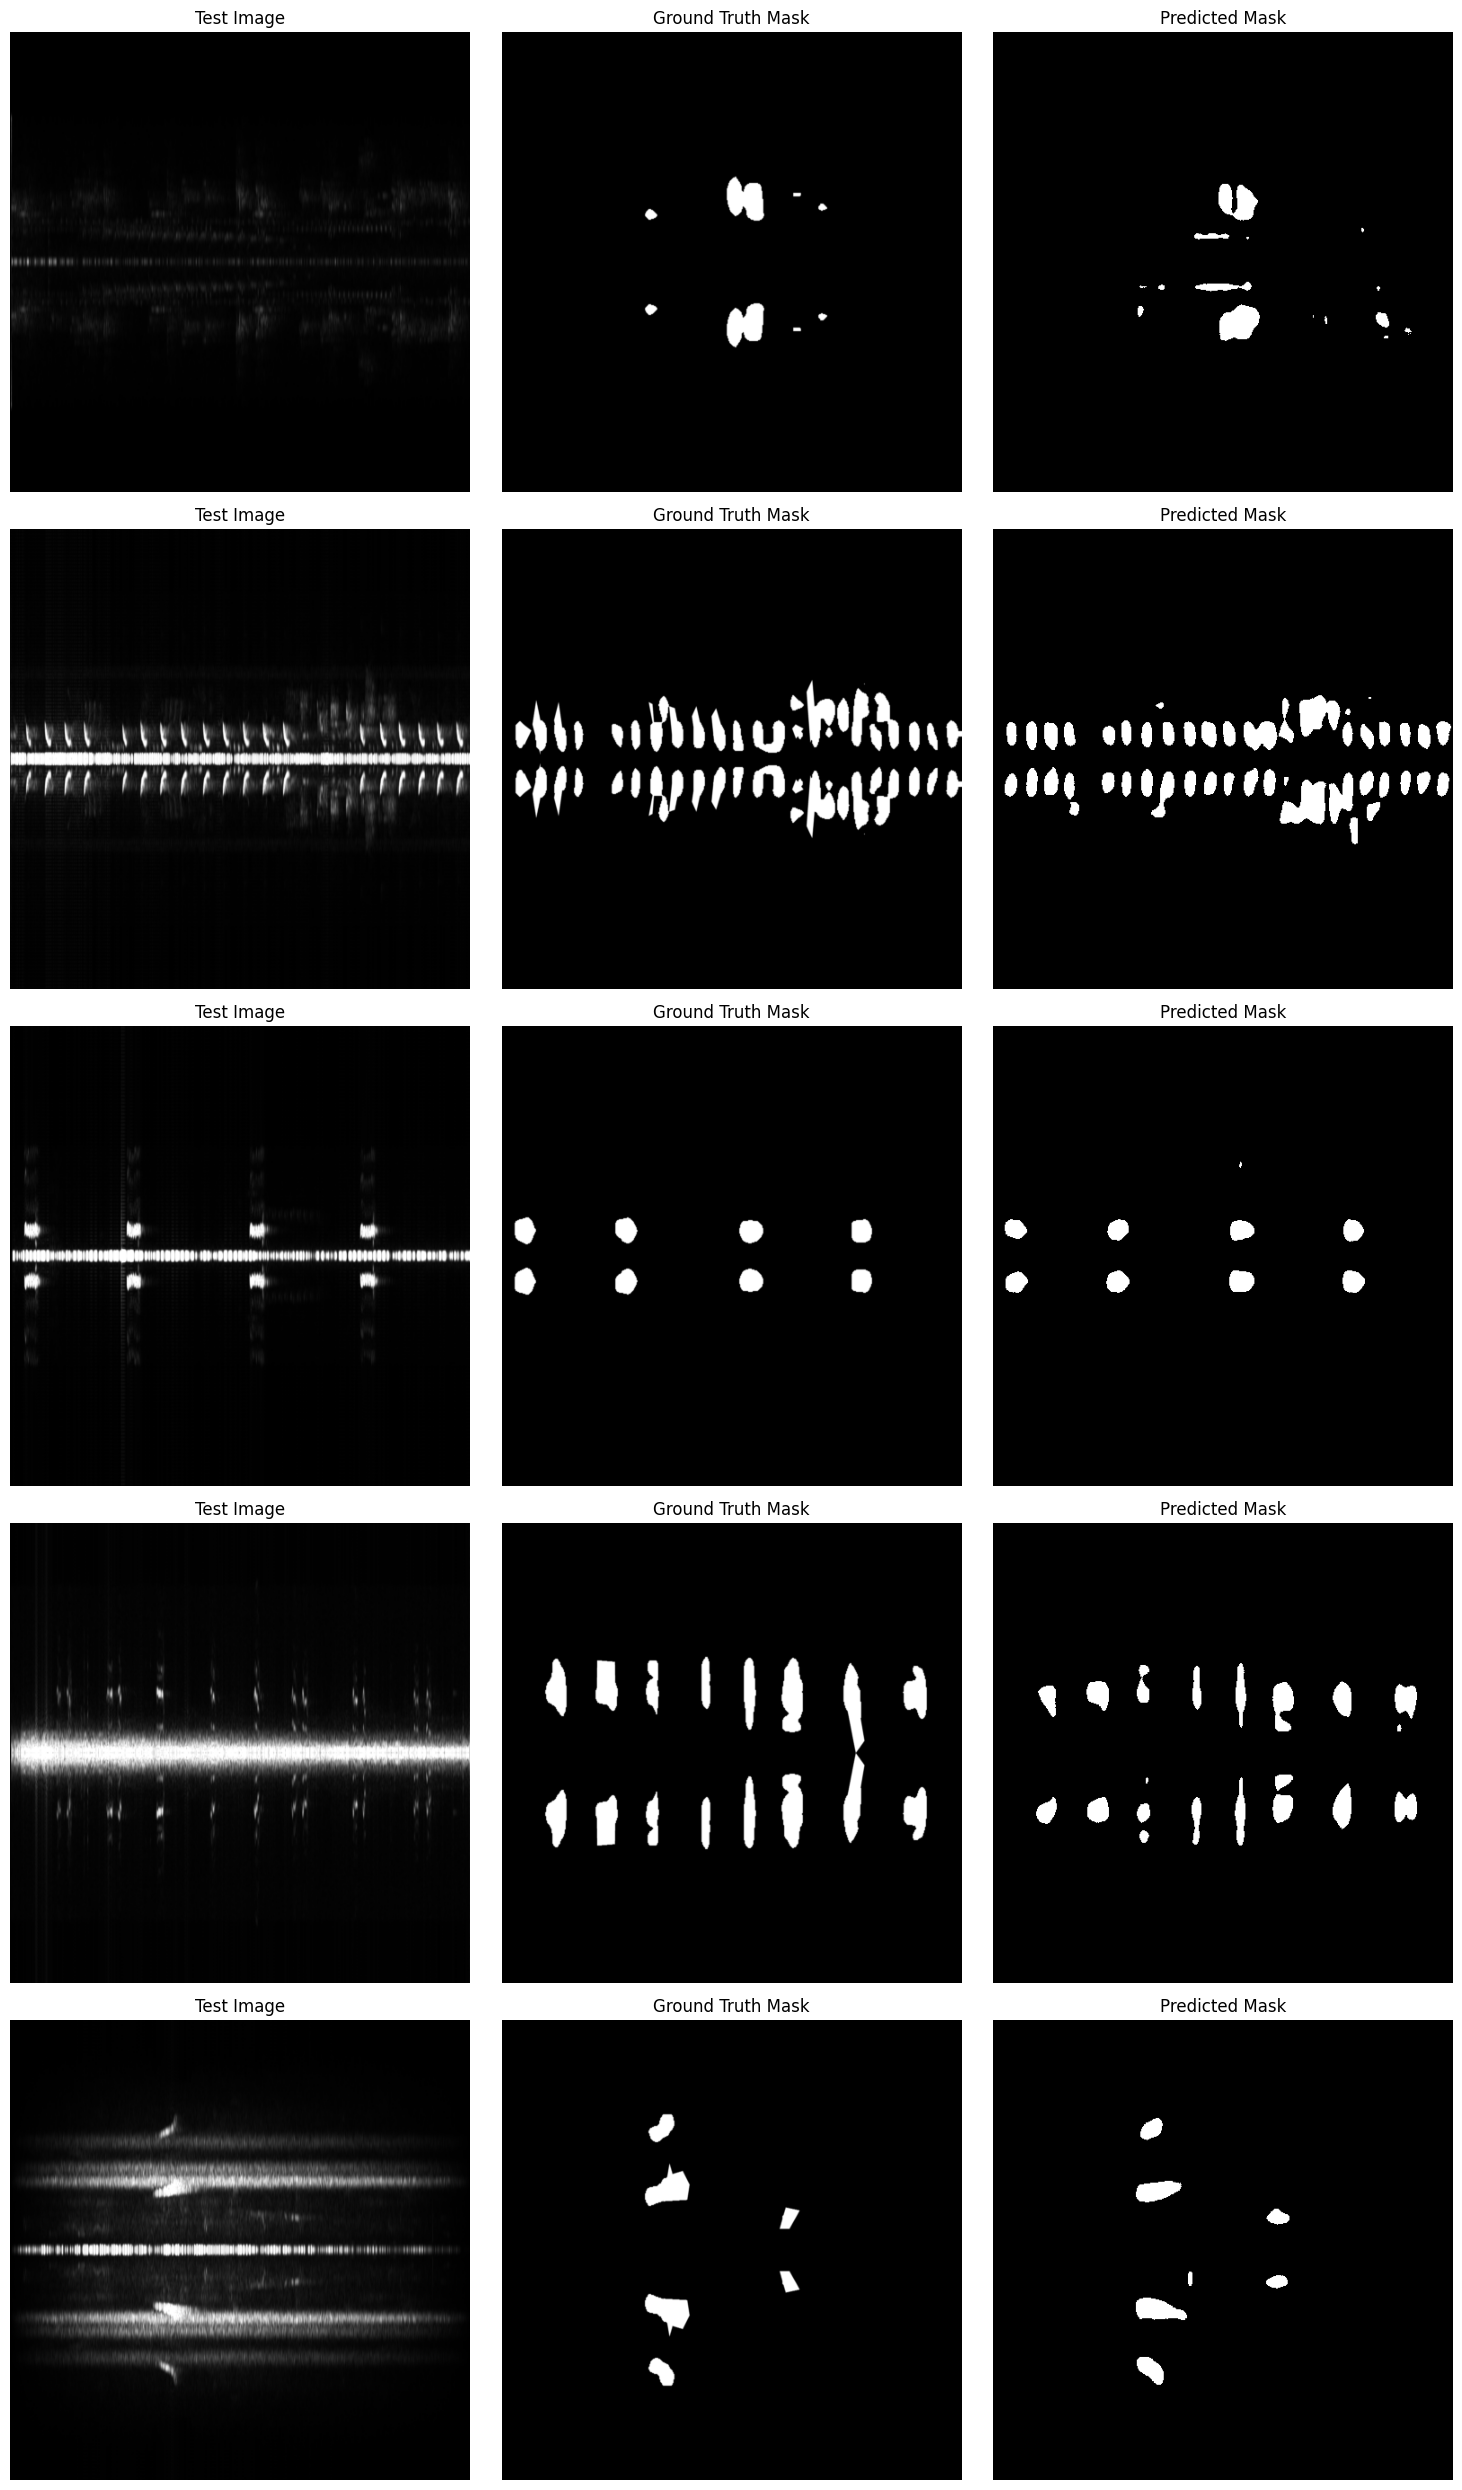

 21%|██        | 4/19 [00:13<00:51,  3.45s/it]

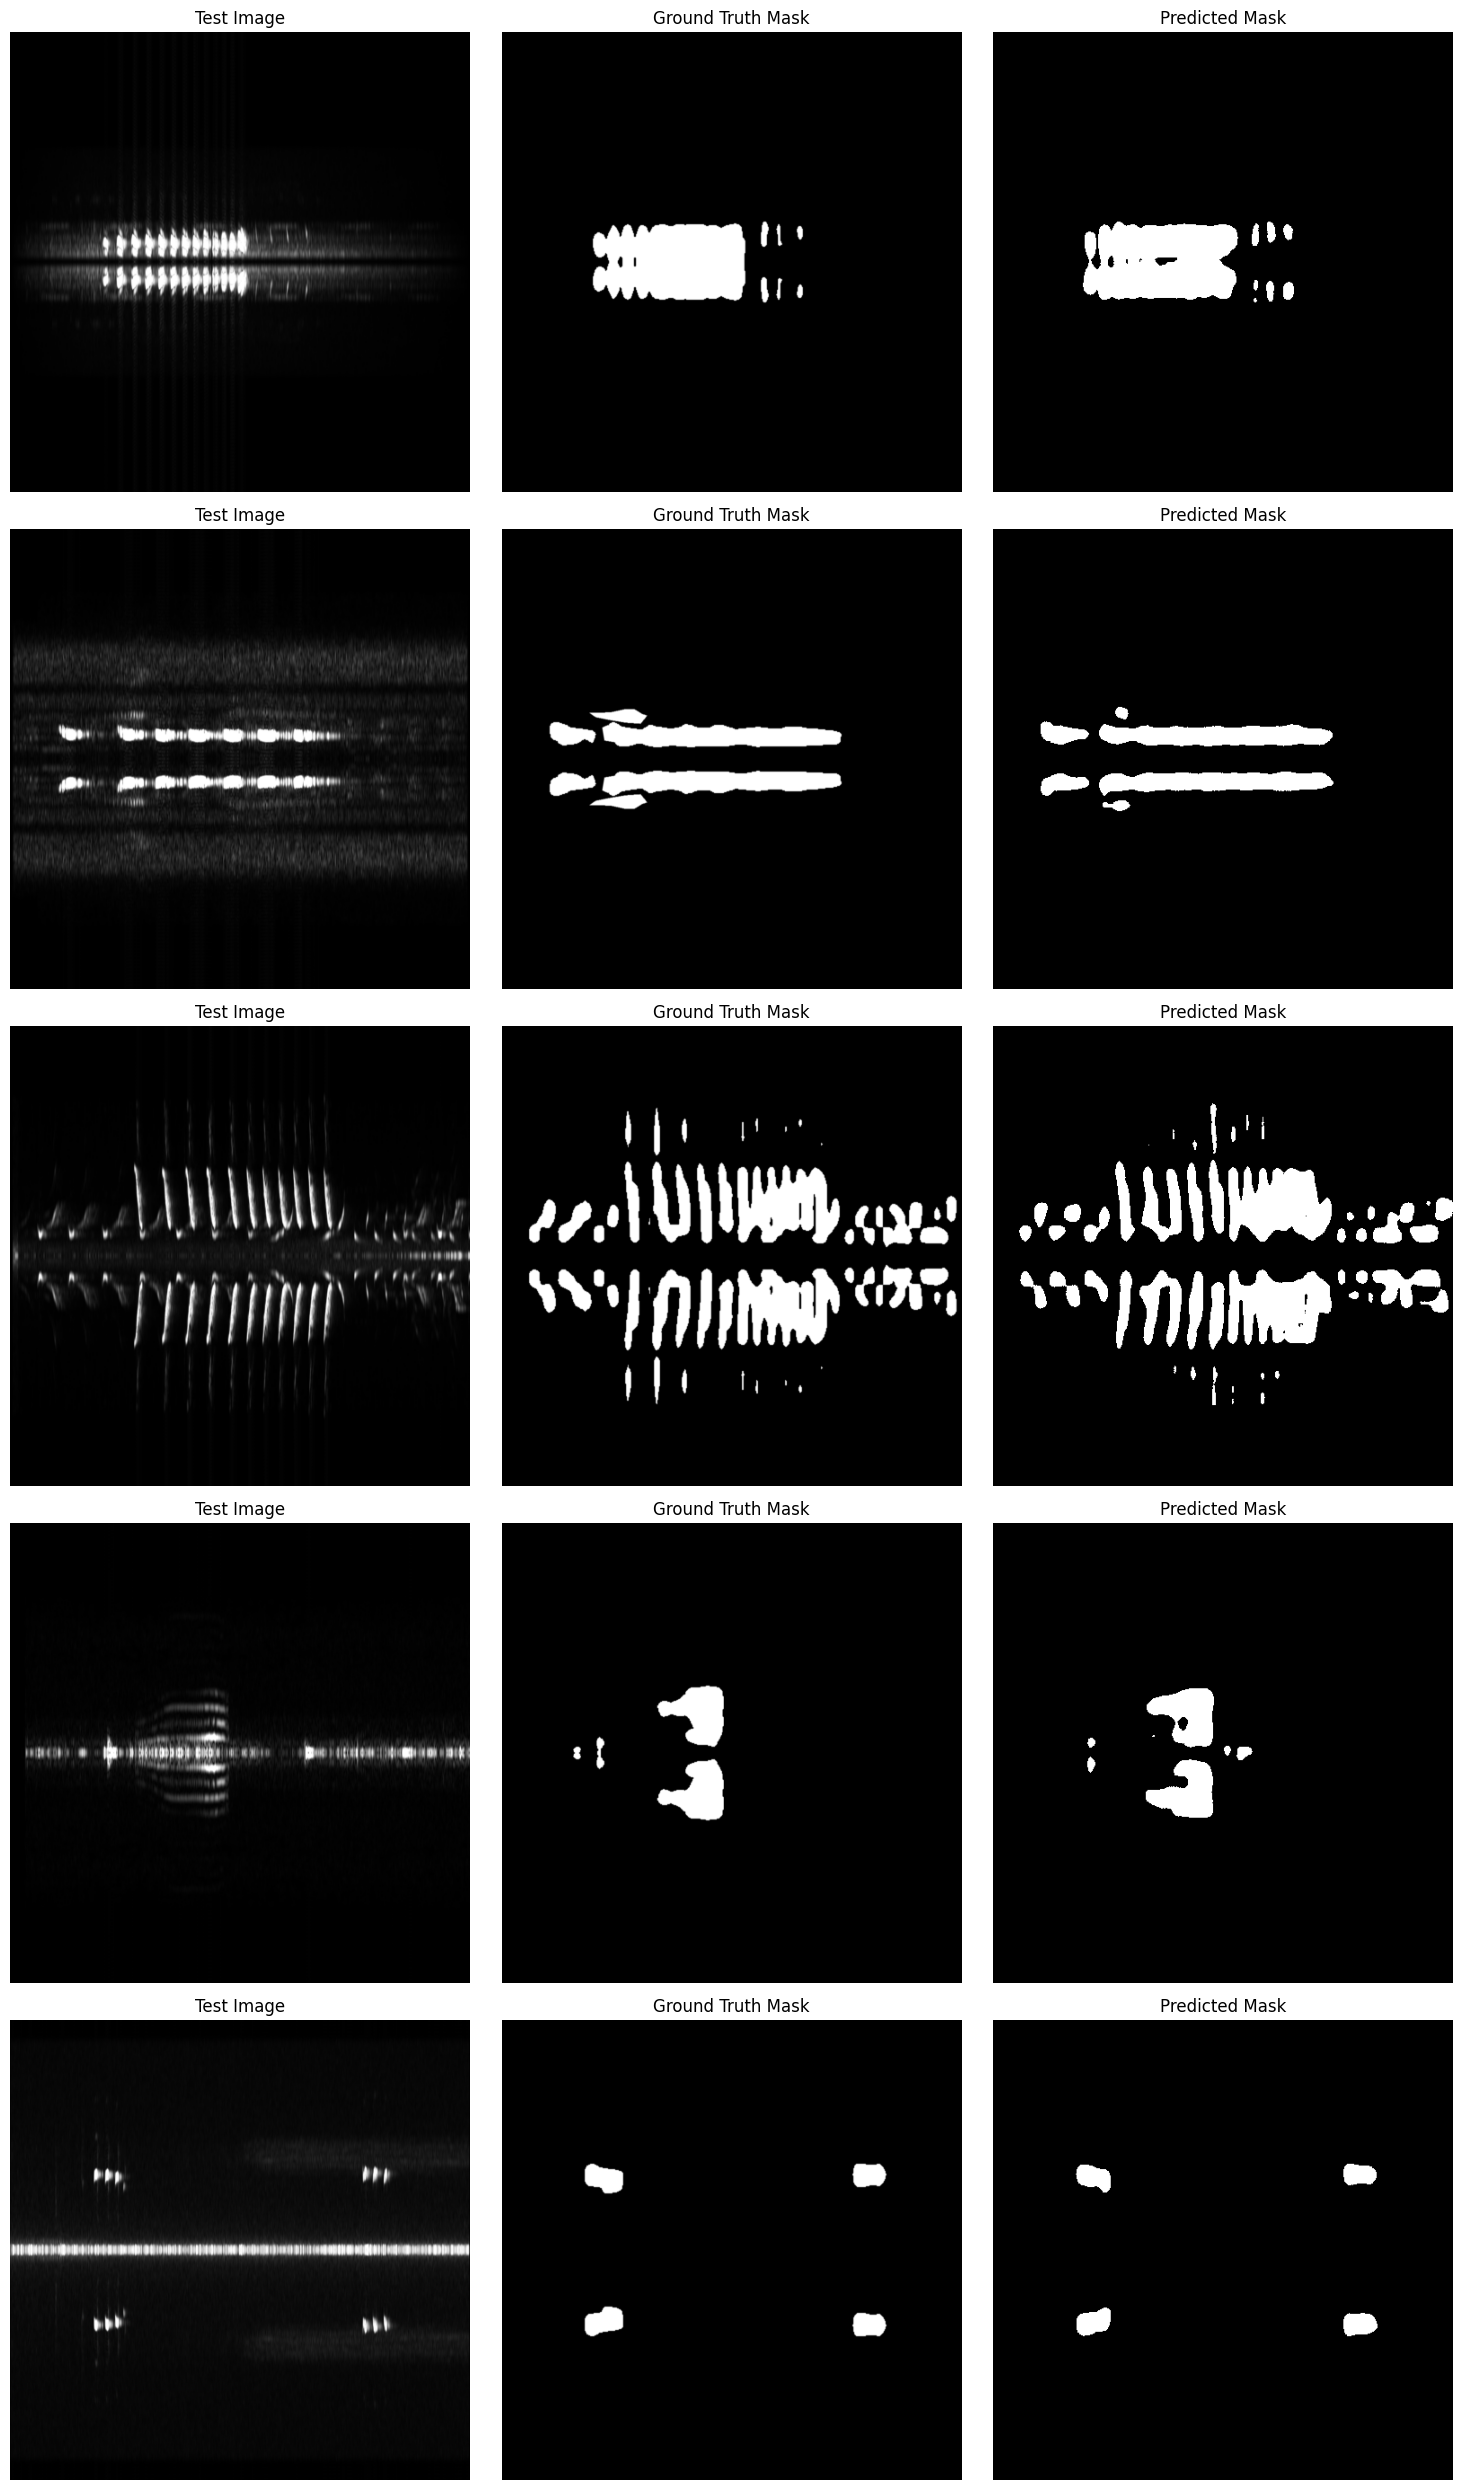

 21%|██        | 4/19 [00:16<01:03,  4.23s/it]


In [45]:
def visualize_results(images, masks, outputs, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    for i in range(num_images):
        image = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = np.squeeze(masks[i].cpu().numpy(), axis=0)
        output = np.squeeze(outputs[i].cpu().numpy(), axis=0)

        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Test Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(output, cmap='gray')
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

def visualize_model_results(model, test_loader, device, num_images_to_visualize=5):
    model.eval()
    visualize_count = 0

    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Convert outputs to binary mask

            if visualize_count < num_images_to_visualize:
                visualize_results(images, masks, outputs, num_images=num_images_to_visualize)
                visualize_count += 1
                if visualize_count >= num_images_to_visualize:
                    break

# Define your model, test_loader, and device as appropriate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_model_results(model, test_loader, device, num_images_to_visualize=5)

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/382944211_Custom_Image_Segmentation_Model_for_Visual_Bird_Sound_Denoising

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.85 -->10 points
     < 0.8  --> 0 points
     >= 0.8 & < 0.85  --> 2 point/0.01 higher
     

(6). Discussion - 10 points